# Instructions

In this challenge, you'll try to predict the severity of car accidents, based on features collected from after-crash police investigation

This [Kaggle challenge](https://www.kaggle.com/c/accident-severity) comprises of 1,000,000 accidents report, split into multiple `.csv` files.

**The goal of the model is to predict the severity of car accidents**. The target variable is called `grav` (for 'gravity') in the file `users.csv`. This variable has four levels, but in this challenge, we'll convert it to a binary classification problem. We will:
- Load data into pandas
- Create a single DataFrame for our problem, where each row is a user involved in an accident
- Extract the features you think would be relevant to predict its severity
- Build a data pipeline that gives you a baseline model
- Then, iterate on the different phase and try to get the best model! 

🔥 **Today is a special challenge** :
- You will send your best score to your batch slack channel!
- The winner will present its notebook to the class during the recap session at 5pm 💪

---
⚠️ **Good practices to follow for large exploratory notebooks**
- Build your Notebook linearily so that it can always be run from top to bottom without any errors
- Clean the outputs of your cells that are not needed
- Clean your variables in memory when you don't need them (especially when they are very large). You can use the python built-in function `del`, or the the **Jupyter nbextentions** `variable_inspector`
- Make heavy use of `table_of_content` and `collapsable_headings` 

# Data sourcing

Let's get started! The data we want to use is from the `csv` files in `/data/data_training`

## Loading data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
cara = pd.read_csv("data_training/caracteristics.csv", encoding="ISO-8859-1")
users = pd.read_csv("data_training/users.csv", encoding="ISO-8859-1")
places = pd.read_csv("data_training/places.csv", encoding="ISO-8859-1")
vehicles = pd.read_csv("data_training/vehicles.csv", encoding="ISO-8859-1")

/Users/jessicaparker/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


❓ Explore the different tables, and the different variables using `challenge_variable.md`, which provides a description of features. More details can be found [here](https://static.data.gouv.fr/resources/base-de-donnees-accidents-corporels-de-la-circulation/20180927-112352/description-des-bases-de-donnees-onisr-annees-2005-a-2017.pdf) if needed, or in the [Kaggle](https://www.kaggle.com/ahmedlahlou/accidents-in-france-from-2005-to-2016/discussion) discussion channel. Understand

In [3]:
# Your code below

## Merge datasets

❓ We will create one single dataset where each row should represent a `user` in a car, by merging the data from the different files dataset.  
**Take some time to think about how you would do it yourself**, and only then, read carefully through the code below to understand exactly what we did

In [4]:
# Merge caracteristics and places on 'Num_Acc'
data = cara.merge(places, on='Num_Acc')

In [5]:
# Create a common key to merge users amd vehicles on
users['Num_Acc_num_veh'] = users['Num_Acc'].map(lambda x: str(x)) + users['num_veh']
vehicles['Num_Acc_num_veh'] = vehicles['Num_Acc'].map(lambda x: str(x)) + vehicles['num_veh']
# Remove useless columns
vehicles = vehicles.drop(columns=['index'])
users = users.drop(columns=['index', 'Num_Acc', 'num_veh'])
# Merge vehicles and users
tmp = vehicles.merge(users, on='Num_Acc_num_veh', how='inner')

In [6]:
# Merge all datasets on 'Num_Acc'
data = data.merge(tmp, on='Num_Acc', how='inner')
del tmp

In [7]:
data["grav"].value_counts()

1    492921
4    430413
3    253787
2     32241
Name: grav, dtype: int64

# Preprocessing

We will apply some preprocessing methods like standardization or missing values removal or imputing.
Remember to look at `challenge_variable.md` for a description of features.

## Clean Dataset

In [8]:
# drop lines without targets (if any)
data_cleaned = data[~np.isnan(data.grav)]

In [9]:
# Check whih features with highest ratio of NaN per column
(data_cleaned.isna().sum() / data_cleaned.shape[0]).sort_values(ascending=False)

v2                 0.953958
lat                0.632648
long               0.632648
gps                0.631134
pr1                0.463472
pr                 0.462609
v1                 0.383683
adr                0.184124
voie               0.048149
place              0.032898
secu               0.011189
lartpc             0.003175
larrout            0.002416
an_nais            0.001841
nbv                0.001731
vosp               0.001060
actp               0.000882
locp               0.000867
etatp              0.000825
infra              0.000662
env1               0.000653
plan               0.000445
prof               0.000443
surf               0.000427
obs                0.000427
circ               0.000392
situ               0.000355
obsm               0.000236
trajet             0.000186
manv               0.000106
choc               0.000064
atm                0.000039
col                0.000017
com                0.000005
catr               0.000002
hrmn               0

In [10]:
# Remove too incomplete features
too_incomplete_features=[
    'locp', 'actp', 'etatp'
]

In [11]:
# Remove features that can be safely considered useless for the predictive power of our model
useless_features=[
    'v2', 'lat', 'long', 'gps', 'pr1', 'pr', 'v1', 'adr', 'voie',
    'index_x', 'Num_Acc', 'Num_Acc_num_veh', 'Num_Acc', 'num_veh', 'index_y',
    'jour', 'an',
    'dep', 'com', 'env1',
]

In [12]:
data_cleaned.drop(columns=too_incomplete_features+useless_features, inplace=True)

In [13]:
data_cleaned.columns

Index(['mois', 'hrmn', 'lum', 'agg', 'int', 'atm', 'col', 'catr', 'circ',
       'nbv', 'vosp', 'prof', 'plan', 'lartpc', 'larrout', 'surf', 'infra',
       'situ', 'senc', 'catv', 'occutc', 'obs', 'obsm', 'choc', 'manv',
       'place', 'catu', 'grav', 'sexe', 'trajet', 'secu', 'an_nais'],
      dtype='object')

In [14]:
data_cleaned["senc"].value_counts()

0.0    1198624
1.0       8471
2.0       2267
Name: senc, dtype: int64

We now have a `data_cleaned` dataset! Let's now engineer our features as needed

## Prepare features and target

### Numerical features

In [15]:
data_cleaned.head()

,mois,hrmn,lum,agg,int,atm,col,catr,circ,nbv,...,obsm,choc,manv,place,catu,grav,sexe,trajet,secu,an_nais
0,11,130,3,2,1,1.0,3.0,9.0,2.0,2.0,...,0.0,1.0,1.0,1.0,1,3,1,5.0,21.0,1994.0
1,11,130,3,2,1,1.0,3.0,9.0,2.0,2.0,...,0.0,2.0,16.0,1.0,1,1,1,1.0,11.0,1967.0
2,1,1145,1,2,2,7.0,3.0,3.0,2.0,2.0,...,2.0,2.0,19.0,1.0,1,1,1,5.0,11.0,1956.0
3,1,1145,1,2,2,7.0,3.0,3.0,2.0,2.0,...,2.0,8.0,1.0,1.0,1,1,1,5.0,11.0,1948.0
4,1,1145,1,2,2,7.0,3.0,3.0,2.0,2.0,...,2.0,8.0,1.0,3.0,2,3,2,0.0,11.0,1950.0


In [16]:
# List numerical features to process
features_numerical = ["nbv","lartpc","larrout","occutc"]

/Users/jessicaparker/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


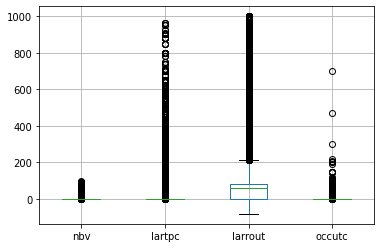

In [17]:


data_cleaned[features_numerical].boxplot()

In [18]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, StandardScaler

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
data_cleaned[features_numerical] = imp_mean.fit_transform(data_cleaned[features_numerical])

def preprocess_numerical_features(X):
#     Returns a new DataFrame with
#     - Missing values replaced by Column Mean
#     - Features Standard Scaled
#     - Original Features names kept in the DataFrame
        ct = ColumnTransformer([
         ("s_scaler", StandardScaler(), ['nbv']),
         ("r_scaler", RobustScaler(), ['lartpc', 'larrout','occutc'])])
        X = ct.fit_transform(X)
        return X
        




In [19]:
data_cleaned[features_numerical] = preprocess_numerical_features(data_cleaned[features_numerical])

In [20]:
# Check your code below
data_cleaned[features_numerical].isnull().sum()

nbv        0
lartpc     0
larrout    0
occutc     0
dtype: int64

In [21]:
# Check your code below
data_cleaned[features_numerical]

,nbv,lartpc,larrout,occutc
0,-0.052801,0.0,-0.341176,0.0
1,-0.052801,0.0,-0.341176,0.0
2,-0.052801,0.0,-0.070588,0.0
3,-0.052801,0.0,-0.070588,0.0
4,-0.052801,0.0,-0.070588,0.0
...,...,...,...,...
1209357,-1.248930,0.0,1.047059,0.0
1209358,-1.248930,0.0,1.047059,0.0
1209359,-1.248930,0.0,1.047059,0.0
1209360,-0.052801,20.0,0.164706,0.0


❓ Do you get a Warning "A value is trying to be set on a copy of a slice from a DataFrame"?
If so, it may be because you are trying to modify the input DataFrame `data_cleaned`!

Read this [important blog on copy vs. view](https://www.practicaldatascience.org/html/views_and_copies_in_pandas.html) of pandas DataFrame and try to solve your warning by yourself



<details>
    <summary>Hint</summary>

`pd.DataFrame.copy()`
</details>

### (optional) cyclical features

In [22]:
# Do you see any cyclical features to process specifically?
# This can be done after a first baseline model is created.
features_cyclical = ['hr_sin','hr_cos',"mnth_sin","mnth_cos","an_nais"]

data_cleaned["hours"] = data_cleaned["hrmn"]//100


In [23]:
# YOUR CODE BELOW

data_cleaned['hr_sin'] = np.cos(data_cleaned["hours"]*(2.*np.pi/24))
data_cleaned['hr_cos'] = np.cos(data_cleaned["hours"]*(2.*np.pi/24))
data_cleaned['mnth_sin'] = np.sin((data_cleaned.mois-1)*(2.*np.pi/12))
data_cleaned['mnth_cos'] = np.cos((data_cleaned.mois-1)*(2.*np.pi/12)) 

data_cleaned.drop('mois', axis=1, inplace = True)
data_cleaned.drop('hours', axis=1,inplace = True)
data_cleaned.drop('hrmn', axis=1, inplace = True)



In [24]:
# data_cleaned.drop('mois', axis=1, inplace = True)
# data_cleaned.drop('hours', axis=1,inplace = True)
# data_cleaned.drop('hrmn', axis=1, inplace = True)


### Categorical features

❓ Create the last group of feature (categorical features) without hardcoding them manually. Then, create the associated preprocessing method

In [25]:
features_categorical = list(set(data_cleaned.columns) - set(features_numerical) - set(features_cyclical) - {'grav'})
features_categorical

['int',
 'atm',
 'vosp',
 'sexe',
 'catu',
 'manv',
 'agg',
 'obs',
 'infra',
 'trajet',
 'obsm',
 'place',
 'col',
 'secu',
 'circ',
 'surf',
 'situ',
 'lum',
 'prof',
 'senc',
 'plan',
 'catr',
 'catv',
 'choc']

In [26]:
data_cleaned.shape

(1209362, 34)

In [27]:
def preprocess_categorical_features(X):   
    features_categorical = list(set(X.columns) - set(features_numerical)  - {'grav'})
    ''' Returns a new DataFrame with dummified columns'''
    X = pd.get_dummies(X, columns = features_categorical)
    return X

❓ Create the new `data_preprocessed` dataset by concatenating all three preprocessing, and then drop all remaining NaN that could not have been handled previously despite our preprocessing. You should have a (1125397, 216) shape

In [28]:
# YOUR CODE BELOW
data_cleaned[features_categorical].shape

(1209362, 24)

In [29]:
data_cleaned = pd.get_dummies(data_cleaned, columns = features_categorical)


In [30]:
data_cleaned.dropna(inplace = True)

In [31]:
data_cleaned.shape

(1207135, 235)

## Split Dataset
❓ Create X and y, and don't forget to convert the classification into a binary task.

For instance:

```python
data['grav_binary'] = data['grav'].replace({1: 0, 4: 0, 2: 1, 3: 1})
```

### You should scale/fit/transform AFTER you split but for time's sake and the for sake of my sanity, I will follow the excercise.

In [32]:
data_cleaned_sample = data_cleaned.sample(1_000)
data_cleaned_sample = data_cleaned.drop("an_nais", axis = 1)

In [33]:
# Create X and y
X = data_cleaned_sample.drop('grav', axis=1)
data_cleaned_sample ['grav_binary'] = data_cleaned_sample ['grav'].replace({1: 0, 4: 0, 2: 1, 3: 1})
y = data_cleaned_sample ['grav_binary']

In [34]:
# Create a smaller dataset (X_small, y_small) for investigation purpose only
# X_small = X.sample(n = 10_000)
# y_small = y.sample(n = 10_000)

In [35]:
# Train Test Split both datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

In [36]:
# ##Because they had us scale before we split, I am applying the scaling methods here on the train/test sets. 

# imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
# X_train[features_numerical] = imp_mean.fit_transform(X_train[features_numerical] )
# X_train[features_numerical] = imp_mean.transform(X_train[features_numerical] )



# X_train[features_numerical] = preprocess_numerical_features(X_train[features_numerical])
# ##This is bot fitting and transforming the test data on the test data but oh well, moving on because of time. 
# X_test[features_numerical] = preprocess_numerical_features(X_test[features_numerical])


# Features exploration

You now have a dataset ready for training! 
**Skip directly to section 5 to get a baseline model working ASAP**, and only then come back to this section 4 if you want to better understand your X and get inspiration for the best model to use, or for some feature selection to reduce model complexity

## Visualization

❓Investigate your X. Are features strongly correlated? Are some feature more important than other?

In [37]:
# YOUR CODE HERE
# import seaborn as sns
# sns.heatmap(X.corr())


## PCA

❓Fit a PCA and plot the cumulated sum of explained variance ratio of your Principal Component. Do you see any clear elbow?

In [38]:
# YOUR CODE HERE

## Forest-based most important features

❓ Fit a default RandomForestClassifier on a small smaple to estimate the top 20 feature importance. Do they make intuitive sense to your point of view?  Do you see any clear elbow for dimension-reduction?

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

forest = RandomForestClassifier()

# Hyperparameter Grid
search_space = {'min_samples_split' : randint(2,25), 'max_depth':randint(2,25)}

# Instanciate Grid Search
search = RandomizedSearchCV(forest, param_distributions = search_space, n_jobs=-1, scoring = 'accuracy', cv = 10, n_iter = 10)

# Fit search
search.fit(X_train,y_train)
search.score(X_test, y_test)
#Best parameters
search.best_params_
model = search.best_estimator_
model.fit(X_train,y_train)
model.score(X_test,y_test)

❓ (Optional) There are better ways to estimate feature importance in a RandomForest. Feel free to try to two following options

**Option 1** : Recursive-method
1. Train a first model, note top1 feature (computed based on the gini-explicative power of the feature, in each tree)
2. Remove top1 from your X and retrain a RandomForest. Note top1 feature and it's relative importance
3. Loop

**Option 2** : Permutation-method ([sklearn.inspection.permutation_importance](https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance)), works with any model!
1. Train a first model, keep track of its accuracy
2. Take one feature and shuffle its columns. Compute new accuracy of the corrupted dataset, and note by how much it has been reduced.
3. Loop over all features and rank them by accuracy reduction

In [ ]:
# YOUR CODE HERE

# Modeling

## Baseline performance metrics

❓ What is the class balance of your target?  

What would be the most dumb baseline to beat? Print the `classification_report` of this dumb model.

In [ ]:
# YOUR CODE HERE
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

# instantiate model
logreg = LogisticRegression()
y_pred = logreg.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred))


❓ If you don't want to favor any class over the other, what would be a good performance metric for your problem? 
Take some time to think before reading the answer! It's not that obvious.

<details>
    <summary>Answer</summary>

In such an unbalanced problem, accuracy is meaningless: A very dumb model predicting always zeros would have great accuracy, to the detriment of the predictive power of class  1, which has precision and recall equal to zero!
    
The non-weighted mean between both f1 score of each class called `f1_macro` would be a good measure for this type of problem.
</details>

## Simple Model (A first iteration)

❓ Create a simple model, fast to train, to classify the severity of the accidents. Start simple. Don't forget to fit on your training set and evaluate the score on your test set. Can you beat the Baseline? What about its Accuracy? Measure the time it takes on the full dataset, with `%%time` 

In [ ]:
# YOUR CODE BELOW
from sklearn.linear_model import LogisticRegression
#%%time
log_model = LogisticRegression()
log_model.fit(X_train,y_train)
log_model.score(X_test, y_test)

### This does not really beat out "dumb" model...we can do a much better job! 

# 🔥🔥🔥 Advanced Models - LeWagon batch contest ! 🔥🔥🔥

❓ Now it's your turn to shine! Play with different models and try to find the best one on your training set!
- Send your best score (as defined above) to your slack channel without saying which model you used!
- ⚠️ Only send score tested on the `y_test` of complete size (1M+ rows!)
- Feel free to use your X_small for investigation purpose
- If it takes too long to train, simplify your model, or use better feature preprocessing/selection

The winner will present its notebook to the class during the reboot 💪

(Don't forget, your Notebook should be made to be run from top to bottom in one go!)

<details>
    <summary>Some hints</summary>
Take a closer look at feature engineering: Are there some features we haven't correctly preprocessed?  
    
Most of the time, a good dataset trumps a good model!
</details>

In [ ]:
# install dependencies
!pip install deap update_checker tqdm stopit joblib torch
# install xgboost optionally
!pip install xgboost
# install tpot
!pip install tpot
import os
from tpot import TPOTClassifier

In [ ]:
tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2)
# process autoML with TPOT
tpot.fit(X_train, y_train)
# print score
print(tpot.score(X_test, y_test))

### (Optional) - Pipeline most steps (prepross & fit) in one single Sklearn Pipeline